# Homework 4: machine learning

# PART 2

Note that the first cells are the same as in part 1. If you want to go directly to the cell where they diverged, click [here](#diverged)

---
### NOTE: Sometimes we refer to [the original work](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) 

---

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

You need to install `scikit v0.18`: `conda update scikit-learn`

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold

Read and minimal cleanup: for the first part, we need the labels (i.e. colour ratings), so we can't use the points where they don't exist. 

Since we will later `aggregate` the players, it is **important** to note that this doesn't produce inconsistencies because `dyads` is constructed by a join between a `players` table and a `referees` table, so it is natural that the missing values are missing for all instances of a player.

In [3]:
dyads = pd.read_csv("CrowdstormingDataJuly1st.csv", index_col=0)
print(dyads.shape)

dyads.dropna(subset=['rater1'], inplace=True)
print(dyads.shape)

# since both values are missing at the same time, this should be 0:
print(dyads.rater2.isnull().sum())

# the groupby object user later on
group_players = dyads.groupby(level=0)

(146028, 27)
(124621, 27)
0


In [4]:
dyads.head()

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,,
lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


Let's see the numbers: 

<sub>yes, they were done by the other guys, but it's useful to have them at hand:</sub>

Also, they were excluding some referees that have been _carried over_, and that only removes ~3% of the data. Since we're not doing statistics on referees, we won't drop them. Every little data helps :)

In [5]:
print("Number of players: " , dyads.index.unique().size)
print("Number of referees: ", dyads.refNum.unique().size)

Number of players:  1585
Number of referees:  2978


The original analysis mentioned that "*the two raters disagree on 28742 or 19% of the time*". Since there are only 1585 players, it means they ran it on the `dyads` set. _**WHY?**_ That doesn't make sense, so let's just check that the ratings for each player are consistent:

for the group of each player, we check that the number of values in `raterX` is **exactly** one:

In [6]:
def build_player_consitency(player_df):
    """ Needs to return a Series of {col_name: col_value}. """
    return pd.Series({col+"_INconsistent" : (player_df[col].unique().size != 1) 
                                             for col in ['rater1', 'rater2'] })
consistency = group_players.apply(build_player_consitency)
print(consistency.head())
print("Rater1 has been inconsistent %d times" % consistency.rater1_INconsistent.sum())
print("Rater2 has been inconsistent %d times" % consistency.rater2_INconsistent.sum())

                       rater1_INconsistent rater2_INconsistent
playerShort                                                   
aaron-hughes                         False               False
aaron-hunt                           False               False
aaron-lennon                         False               False
aaron-ramsey                         False               False
abdelhamid-el-kaoutari               False               False
Rater1 has been inconsistent 0 times
Rater2 has been inconsistent 0 times


OK, so they _ARE_ consistent. This means that their statistic doesn't account for players who have more matches than others, so the numbers are skewed. Let's check again, this time on _unique_ players

In [7]:
player_ratings = group_players.agg({'rater1':'first', 'rater2':'first'})
diffs = player_ratings.rater1 - player_ratings.rater2
print("The raters disagree for {p:.3f}% of the players".format(p=(diffs != 0).sum() / len(diffs) ))

print("Diffs std dev: ", diffs.std())

max_diff = diffs.abs().max()
num_occur = (diffs.abs() == max_diff).sum()
print("Max disagreement value {0}, occuring {1} times".format(max_diff * 4, num_occur)) # *4 to pass from float to int

The raters disagree for 0.239% of the players
Diffs std dev:  0.11594303556667578
Max disagreement value 2.0, occuring 2 times


So this means:
  1. that there is slightly more agreement between the raters for players who have more entries in `dyads` i.e. who played under more referees
  2. that if we use both labels, using `accuracy` as a measure of performance is not a very good idea. Keep in mind that the differences are not ordered, so it could have an impact double as big on the accuracy, i.e. at most $1 - 2 * \mathit{disagreementPercentage} = 1 - 2 * 0.24 \approx 0.5 $

#### Curiosity
Who are the 'controversial' guys :) ?

In [8]:
diffs[diffs.abs() == max_diff]

playerShort
kyle-walker    -0.5
mario-goetze   -0.5
dtype: float64

<img style='float:left' alt='Kyle-walker' src='http://www.thefootballsocial.co.uk/images/players/Tottenham%20Hotspur/Kyle%20Walker.jpg' /> <img alt='Mario_Goetze' src='http://i0.web.de/image/176/31756176,pd=2/mario-goetze.jpg' width=300/>

## Feature selection

Aggregate the data for each player we consider the following variables:
- the height and weight of the player
- The total amount of games played
- The total amount of victories, ties and defeats
- the total number of goals made
- The total number of red cards, yellow reds and yellow cards received
- The respective ratings
- The league country

In [42]:
players = group_players.agg({'height':'first', 'weight':'first', 'games':'sum', 
                             'victories':'sum','defeats':'sum', 'ties': 'sum', 'goals':'sum', 
                             'redCards':'sum', 'yellowReds': 'sum', 'yellowCards':'sum', 
                             'leagueCountry':'first', 'rater1':'median', 'rater2':'median'})
print(players.shape)
players.head()

(1585, 13)


,rater1,yellowCards,ties,rater2,weight,redCards,height,yellowReds,victories,leagueCountry,games,defeats,goals
playerShort,,,,,,,,,,,,,
aaron-hughes,0.25,19,179,0.00,71.0,0,182.0,0,247,England,654,228,9
aaron-hunt,0.00,42,73,0.25,73.0,1,183.0,0,141,Germany,336,122,62
aaron-lennon,0.25,11,97,0.25,63.0,0,165.0,0,200,England,412,115,31
aaron-ramsey,0.00,31,42,0.00,76.0,1,178.0,0,150,England,260,68,39
abdelhamid-el-kaoutari,0.25,8,40,0.25,73.0,2,180.0,4,41,France,124,43,1


There are some leftover values with null in the weight and height columns

In [43]:
players.isnull().sum()

rater1            0
yellowCards       0
ties              0
rater2            0
weight           21
redCards          0
height            3
yellowReds        0
victories         0
leagueCountry     0
games             0
defeats           0
goals             0
dtype: int64

If the weight or the height is NaN we replace it by the median height and weight of all the players (switch_median = True). As an alternative the replacement can be done using the average (switch_median = False)

In [44]:
switch_median = True
if(switch_median):
    med_height = players['height'].median()
    med_weight = players['weight'].median()
    players['height'] = players['height'].fillna(value=med_height)
    players['weight'] = players['weight'].fillna(value=med_weight)
else:
    av_height = players['height'].mean()
    av_weight = players['weight'].mean()
    players['height'] = players['height'].fillna(value=av_height)
    players['weight'] = players['weight'].fillna(value=av_weight)

Create dummy variables from leagueCountry (categorical) feature. After adding the dummy variables indicating in which country the player plays and removing the feature with the actual strings we have to take care of the dummy variable trap. In essence we have 4 countries but if we keep all for them it will be redundant as we can infer one country from the other 3, and such one feature is linearly dependent on the other 3. (for more information: http://www.algosome.com/articles/dummy-variable-trap-regression.html) 

In [45]:
leagueCountries_dummies = pd.get_dummies(players['leagueCountry'])
players = pd.concat([players, leagueCountries_dummies], axis=1)      
players.drop(['leagueCountry', 'Spain'], inplace=True, axis=1)
players.head(3)

,rater1,yellowCards,ties,rater2,weight,redCards,height,yellowReds,victories,games,defeats,goals,England,France,Germany
playerShort,,,,,,,,,,,,,,,
aaron-hughes,0.25,19,179,0.00,71.0,0,182.0,0,247,654,228,9,1.0,0.0,0.0
aaron-hunt,0.00,42,73,0.25,73.0,1,183.0,0,141,336,122,62,0.0,0.0,1.0
aaron-lennon,0.25,11,97,0.25,63.0,0,165.0,0,200,412,115,31,1.0,0.0,0.0


Convert the new added dummy variables from float to int

In [46]:
players['England'] = players['England'].astype(int)
players['France'] = players['France'].astype(int)
players['Germany'] = players['Germany'].astype(int)

In [47]:
players.head(3)

,rater1,yellowCards,ties,rater2,weight,redCards,height,yellowReds,victories,games,defeats,goals,England,France,Germany
playerShort,,,,,,,,,,,,,,,
aaron-hughes,0.25,19,179,0.00,71.0,0,182.0,0,247,654,228,9,1,0,0
aaron-hunt,0.00,42,73,0.25,73.0,1,183.0,0,141,336,122,62,0,0,1
aaron-lennon,0.25,11,97,0.25,63.0,0,165.0,0,200,412,115,31,1,0,0


Liwekise the column 'games' = 'ties' + 'defeats' + 'victories' and since it is a linear combination of the other three it can be removed

In [48]:
sum(players.games - players.ties - players.defeats - players.victories)

0

In [49]:
players.drop('games', axis=1, inplace=True)
players.head(3)

,rater1,yellowCards,ties,rater2,weight,redCards,height,yellowReds,victories,defeats,goals,England,France,Germany
playerShort,,,,,,,,,,,,,,
aaron-hughes,0.25,19,179,0.00,71.0,0,182.0,0,247,228,9,1,0,0
aaron-hunt,0.00,42,73,0.25,73.0,1,183.0,0,141,122,62,0,0,1
aaron-lennon,0.25,11,97,0.25,63.0,0,165.0,0,200,115,31,1,0,0


We standardize the data. Some features, like the newly added dummy variables do not make much sense to be standardized. Arguably the rater1 and rater2 don't need standardization as well.

In [51]:
features_to_be_standardized = ['height','yellowReds','defeats','redCards','ties','weight',
                              'goals','yellowCards','victories']

def standardize(feature_names):
    for feature_name in feature_names:
        players[feature_name] = \
        (players[feature_name] - players[feature_name].mean()) / (2*players[feature_name].std())

standardize(features_to_be_standardized)
players.head()

,rater1,yellowCards,ties,rater2,weight,redCards,height,yellowReds,victories,defeats,goals,England,France,Germany
playerShort,,,,,,,,,,,,,,
aaron-hughes,0.25,-0.247394,1.800348,0.00,-0.356607,-0.374619,-0.003278,-0.341141,0.911628,1.872586,-0.226273,1,0,0
aaron-hunt,0.00,0.212043,0.246118,0.25,-0.214929,-0.000943,0.070944,-0.341141,0.228388,0.587071,0.412009,0,0,1
aaron-lennon,0.25,-0.407198,0.598019,0.25,-0.923316,-0.374619,-1.265058,-0.341141,0.608682,0.502178,0.038675,1,0,0
aaron-ramsey,0.00,-0.007688,-0.208421,0.00,-0.002413,-0.000943,-0.300167,-0.341141,0.286399,-0.067815,0.135019,1,0,0
abdelhamid-el-kaoutari,0.25,-0.467125,-0.237746,0.25,-0.214929,0.372733,-0.151723,1.097870,-0.416178,-0.371002,-0.322617,0,1,0


## Assignment 2: cluster players

We convert the pandas data frame to lists in order to match the expected data format for scikit learn.

Main parameters to consider for kmeans clusterer

- max_iter : int, default: 300
Maximum number of iterations of the k-means algorithm for a single run.

- n_init : int, default: 10
Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

- init : {‘k-means++’, ‘random’ or an ndarray}
Method for initialization, defaults to ‘k-means++’:
‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.
‘random’: choose k observations (rows) at random from data for the initial centroids.
If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.

- algorithm : “auto”, “full” or “elkan”, default=”auto”
K-means algorithm to use. The classical EM-style algorithm is “full”. The “elkan” variation is more efficient by using the triangle inequality, but currently doesn’t support sparse data. “auto” chooses “elkan” for dense data and “full” for sparse data.

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [53]:
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

Helper functions, in case they are needed for quick testing. For completeness it would be ideal to test all feature subsets and find which one has a better silhouette score and in this case in the pick_subset function the lower bound limit should be 1 (the empty set is ignored). However this would require a lot of computation time so the number of feature subsets can be reduced by selecting different bounds on the length of the feature subset.

In [96]:
lower_bound = 2
def pick_subset(element):
    return len(element) >= lower_bound

def prepare_feature_subsets(features):
    return filter(pick_subset, features)

The feature subsets on which the clusterer will be run have the following form:

feature subset = (rater1, rater2) + subset of the other features

In [59]:
columns_without_rater12 = list(filter(lambda a: a != 'rater1' and a != 'rater2', players.columns.values))

Create the feature subsets not containing the rater1 and rater2 features using powerset on the column names. 

In [61]:
subsets_of_other_features = list(powerset(columns_without_rater12))

The actual feature subsets used are extended with rater1 and rater2.

In [73]:
feature_subsets = []
for subs in subsets_of_other_features:
    l = list(subs)
    l.extend(['rater1','rater2'])
    feature_subsets.append(l)
len(feature_subsets)

4096

Before running the clusterer it is important to mention a few things. 
- Firstly even if we run the clusterer on all the feature subsets and select the best one based on the silhouette score it is not guaranteed that this model will be good at separating the players into clusters representing skin tone, the 2 resulting clusters could represent 2 communities of players but not (necessarily) grouped by skin tone.
- Secondly we will introduce another measure to see how good the current model is at clustering players into separate clusters based on skin tone. 
- Thirdly we will select the best models on each measurement score and visualize them.

In [75]:
# MEME = the Most Excellent Measurement Ever
def meme(estimator_labels):
    # here we create a dataframe containing the average rating and the label for each player
    player_clusters = players[["rater1", "rater2"]]
    labels = pd.Series(estimator_labels, index=player_clusters.index)
    player_clusters = player_clusters.assign(labels=labels.values)
    player_clusters['average_rating'] = players[["rater1", "rater2"]].mean(axis=1)
    player_clusters.drop(['rater1', 'rater2'], inplace=True, axis=1)
    
    # next we perform 2 mappings:
    # 1) map the average rating to 1 or 0 if it is bigger and equal than 0.5 and respectively < 0.5
    # 2) map the average rating to 0 or 1 if it is bigger and equal than 0.5 and respectively < 0.5
    player_clusters['average_rating_opt1'] = \
    player_clusters['average_rating'].apply(lambda x: 1 if x >= 0.5 else 0)
    player_clusters['average_rating_opt2'] = \
    player_clusters['average_rating'].apply(lambda x: 0 if x >= 0.5 else 1)
    
    # we need 2 mappings to see which provides the smaller error
    # the error represents the total number of misplaced labels, 
    # i.e. it works like: sum(xor(label, map_value)) over all labels
    error_opt1 = sum(abs(player_clusters['labels'] - player_clusters['average_rating_opt1']))
    error_opt2 = sum(abs(player_clusters['labels'] - player_clusters['average_rating_opt2']))
    
    # the second return value is to know which mapping was used for future reference
    if(error_opt1 < error_opt2):
        return error_opt1, 1
    else:
        return error_opt2, 2

Run the clusterer on each feature subset

In [92]:
def run_clusterer(feature_sets, save_all = False):
    # initialize Kmeans estimator
    estimator = KMeans(n_clusters=2, random_state=0)
    
    # initialize storing variables
    best_silhouette = -1
    best_sil_feature_subset = feature_sets[0]
    best_meme = len(players.index)
    best_meme_mapping = 0
    best_meme_feature_subset = feature_sets[0]
    
    all_feature_results = []
    counter = 0
    for feature_subset in feature_sets:
        X = players[list(feature_subset)]
        estimator.fit(X)
        # compute silhouette score for this particular model
        silhouette_avg = silhouette_score(X, estimator.labels_)
        if(silhouette_avg > best_silhouette):
            best_silhouette = silhouette_avg
            best_sil_feature_subset = feature_subset
        # compute meme score for this particular model
        meme_score, meme_mapping = meme(estimator.labels_)
        if(meme_score < best_meme):
            best_meme = meme_score
            best_meme_mapping = meme_mapping
            best_meme_feature_subset = feature_subset
        # just a counter printer to monitor progress, as it will take some minutes to complete
        if(counter % 250 == 0):
            print("Counter ", counter)
            print("For n_clusters =", 2, "The avg silhouette_score is :", silhouette_avg)
            print("For n_clusters =", 2, "The meme score is :", meme_score)
        counter += 1
        if(save_all):
            all_feature_results.append([feature_subset, silhouette_avg, meme_score, meme_mapping])
    if(save_all):
        return all_feature_results
    else:
        return best_sil_feature_subset, best_meme_feature_subset, best_meme_mapping

In [93]:
best_sil_features, best_meme_features, best_meme_mapping = run_clusterer(feature_subsets)

Counter  0
For n_clusters = 2 The avg silhouette_score is : 0.687370433582
For n_clusters = 2 The meme score is : 0
Counter  250
For n_clusters = 2 The avg silhouette_score is : 0.36438900771
For n_clusters = 2 The meme score is : 546
Counter  500
For n_clusters = 2 The avg silhouette_score is : 0.267734621045
For n_clusters = 2 The meme score is : 630
Counter  750
For n_clusters = 2 The avg silhouette_score is : 0.244976283038
For n_clusters = 2 The meme score is : 670
Counter  1000
For n_clusters = 2 The avg silhouette_score is : 0.329183105041
For n_clusters = 2 The meme score is : 589
Counter  1250
For n_clusters = 2 The avg silhouette_score is : 0.319903780379
For n_clusters = 2 The meme score is : 656
Counter  1500
For n_clusters = 2 The avg silhouette_score is : 0.345176816027
For n_clusters = 2 The meme score is : 568
Counter  1750
For n_clusters = 2 The avg silhouette_score is : 0.249638721238
For n_clusters = 2 The meme score is : 702
Counter  2000
For n_clusters = 2 The avg 

In [94]:
best_sil_features

['rater1', 'rater2']

In [95]:
best_meme_features

['rater1', 'rater2']

A short commentary on the results:

1) There is no surprise that we got the best meme features to be rater1 and rater2 as these are the values meme is based on

2) Not necessarily a surprise but the best silhouette score was also obtained using only the rater1 and rater2 features

For the sake of completion we will run the clusterer on all possible subsets (except the feature subsets with cardinality <= 1 as it will give too much advantage for the binary features like 'England', 'France', 'Germany'). We will store the silhouette and meme results for each subset this time and order them at the end. After that we can see what place the feature subset {'rater1', 'rater2'} has in the overall silhouette ranking.

In [99]:
all_feature_subsets = list(prepare_feature_subsets(list(powerset(players.columns.values))))
len(all_feature_subsets)

16369

In [100]:
all_feature_subsets_res = run_clusterer(all_feature_subsets, True)

Counter  0
For n_clusters = 2 The avg silhouette_score is : 0.468429608182
For n_clusters = 2 The meme score is : 647
Counter  250
For n_clusters = 2 The avg silhouette_score is : 0.3557309144
For n_clusters = 2 The meme score is : 632
Counter  500
For n_clusters = 2 The avg silhouette_score is : 0.436165187823
For n_clusters = 2 The meme score is : 613
Counter  750
For n_clusters = 2 The avg silhouette_score is : 0.32485620864
For n_clusters = 2 The meme score is : 707
Counter  1000
For n_clusters = 2 The avg silhouette_score is : 0.390802617233
For n_clusters = 2 The meme score is : 581
Counter  1250
For n_clusters = 2 The avg silhouette_score is : 0.291295364701
For n_clusters = 2 The meme score is : 781
Counter  1500
For n_clusters = 2 The avg silhouette_score is : 0.351829395749
For n_clusters = 2 The meme score is : 692
Counter  1750
For n_clusters = 2 The avg silhouette_score is : 0.277837193257
For n_clusters = 2 The meme score is : 701
Counter  2000
For n_clusters = 2 The avg 

In [178]:
# in order to not rerun the clusterer as it takes almost an hour
copy_all_feature_subsets_res = all_feature_subsets_res

Convert the above list of lists into a dataframe

In [105]:
headers = ['Features', 'Silhouette', 'Meme', 'Meme map type']
features_summary = pd.DataFrame(copy_all_feature_subsets_res, columns = headers)
features_summary.head()

,Features,Silhouette,Meme,Meme map type
0,"(rater1, yellowCards)",0.468430,647,1
1,"(rater1, ties)",0.440832,711,1
2,"(rater1, rater2)",0.687370,0,2
3,"(rater1, weight)",0.410289,780,2
4,"(rater1, redCards)",0.538156,568,1


Sort by silhouette score. We observe that from all the feature combinations used {'rater1', 'rater2'} places 10th regarding silhouette score. The first 9 feature subsets rely on the binary features which unsurprisingly work better in obtaining 2 cluster communities, though they do not create a good separation based on skin tone.

In [110]:
features_summary_sorted_sil = features_summary.sort_values(by='Silhouette', ascending = False)
features_summary_sorted_sil.head(10)

,Features,Silhouette,Meme,Meme map type
90,"(France, Germany)",0.773512,728,1
88,"(England, France)",0.767516,529,2
11,"(rater1, France)",0.732798,405,2
44,"(rater2, France)",0.731883,405,2
89,"(England, Germany)",0.729113,728,1
12,"(rater1, Germany)",0.726277,728,1
45,"(rater2, Germany)",0.724991,728,1
10,"(rater1, England)",0.721450,529,1
43,"(rater2, England)",0.719952,529,1
2,"(rater1, rater2)",0.687370,0,2


In [111]:
features_summary_sorted_meme = features_summary.sort_values(by='Meme', ascending = True)
features_summary_sorted_meme.head(10)

,Features,Silhouette,Meme,Meme map type
2,"(rater1, rater2)",0.687370,0,2
616,"(rater1, rater2, goals, France)",0.476151,405,2
44,"(rater2, France)",0.731883,405,2
122,"(rater1, rater2, France)",0.632201,405,1
11,"(rater1, France)",0.732798,405,2
330,"(rater2, goals, France)",0.545473,449,1
164,"(rater1, goals, France)",0.546036,450,1
120,"(rater1, rater2, goals)",0.579725,450,1
9,"(rater1, goals)",0.642202,450,1
42,"(rater2, goals)",0.640856,450,2


### Extra: Cluster visualization using PCA dimension reduction

Reduced data represents the projection of the data on the 2 directions  with maximal variance as computed by PCA. Why 2? because it is easier in doing the visualization.

In [171]:
# X_vis can be composed of any features in the players dataframe and they will be reduced
# via PCA to 2 dimensions 
vis_row = 616
X_vis = features_summary.loc[vis_row,'Features']
X_vis  

('rater1', 'rater2', 'goals', 'France')

In [172]:
from sklearn.decomposition import PCA

# pass the matrix containing the features you want to test in fit_transform
# NOTE: X represents the best features under the silhouette score in the previous computation 
reduced_data = PCA(n_components=2).fit_transform(players[list(X_vis)].as_matrix())
kmeans_pca = KMeans(init='k-means++', n_clusters=2)
kmeans_pca.fit(reduced_data)
print(reduced_data.shape)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

(1585, 2)


In [173]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_pca.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

Convert the average rating of the players for the chosen set of features into a list to process it easily afterwards

In [174]:
map_type = features_summary.loc[vis_row,'Meme map type']
player_clusters_vis = players[["rater1", "rater2"]]
labels = pd.Series(kmeans.labels_, index=player_clusters_vis.index)
player_clusters_vis = player_clusters_vis.assign(labels=labels.values)
player_clusters_vis['average_rating'] = players[["rater1", "rater2"]].mean(axis=1)
player_clusters_vis.drop(['rater1', 'rater2'], inplace=True, axis=1)

# 1) map the average rating to 1 or 0 if it is bigger and equal than 0.5 and respectively < 0.5
# 2) map the average rating to 0 or 1 if it is bigger and equal than 0.5 and respectively < 0.5
player_clusters_vis['average_rating_opt2'] = \
player_clusters_vis['average_rating'].apply(lambda x: 0 if x >= 0.5 else 1)
average_rating = player_clusters_vis['average_rating_opt2'].tolist()
if(map_type == 1):
    player_clusters_vis['average_rating_opt1'] = \
    player_clusters_vis['average_rating'].apply(lambda x: 1 if x >= 0.5 else 0)
    average_rating = player_clusters_vis['average_rating_opt1'].tolist()

In [175]:
meme_score_for_reduced_PCA = meme(kmeans_pca.labels_)
print("Meme score: ", meme_score_for_reduced_PCA[0])
silhouette_score_for_reduced_PCA = silhouette_score(players[list(X_vis)], kmeans_pca.labels_)
print("Silhouette score: ", silhouette_score_for_reduced_PCA)

Meme score:  451
Silhouette score:  0.494297758569


Divide the reduced data into 2 subsets:
- reduced data where the corresponding players have an average rating >= 0.5
- reduced data where the corresponding players have an average rating < 0.5

In [176]:
from itertools import compress
def restructure_reduced_data(red_data, avg_rating):
    index_dark = []
    index_light = []
    for i in range(len(avg_rating)):
        if(avg_rating[i] >= 0.5):
            index_dark.append(i)
        else:
            index_light.append(i)
    return red_data[index_dark], red_data[index_light]

(reduced_data_dark, reduced_data_light) = restructure_reduced_data(reduced_data, average_rating)

# Should be 'True' to make sure the dimensions of the subsets correspond to the dimensions of the original 
reduced_data_dark.shape[0]+reduced_data_light.shape[0] == reduced_data.shape[0]

True

[[ 1.15187114  0.18211956]
 [-0.13113361 -0.02073322]]


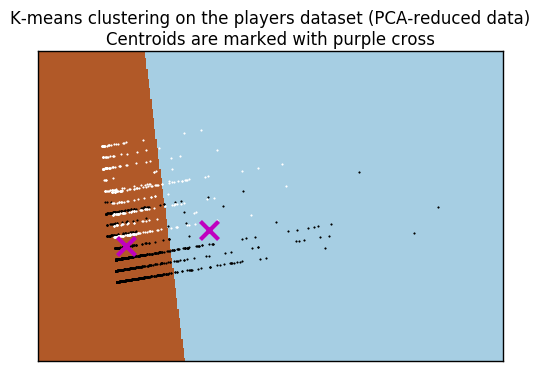

In [177]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data_dark[:, 0], reduced_data_dark[:, 1], 'k.', markersize=2)
plt.plot(reduced_data_light[:, 0], reduced_data_light[:, 1], 'w.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans_pca.cluster_centers_
print(centroids)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='m', zorder=10)
plt.title('K-means clustering on the players dataset (PCA-reduced data)\n'
          'Centroids are marked with purple cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()